# Прогнозирование вероятности оттока пользователей для фитнес-центров
============================================================================================================================

# Оглавление

1. [Загрузка данных](#1)
2. [Предобработка данных](#2)
3. [Исследовательский анализ данных (EDA)](#3)
      * [3.1. Средние значения и стандартные отклонения](#4)
      * [3.2. Анализ тех, кто ушел в отток и тех, кто остался](#5)
          * [3.2.1. Среднее значение в группах](#6)
          * [3.2.2. Столбчатые гистограммы и распределения признаков](#7)
      * [3.3. Матрица корреляций](#8)
4. [Модель прогнозирования оттока клиентов](#9)
      * [4.1. Логистическа регрессия](#10)
      * [4.2. Случайный лес](#11)
      * [4.3. Оценка метрики accuracy, precision и recall для обеих моделей на валидационной выборке](#12)
5. [Кластеризация пользователей](#13)
6. [Выводы и рекомендации](#14)
   
   



# Задание

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. Отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Необходимо провести анализ и подготовить план действий по удержанию клиентов:

- спрогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента;
- сформировать типичные портреты пользователей: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства;
- проанализировать основные признаки, наиболее сильно влияющие на отток;
- сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:

      1) выделить целевые группы клиентов;
      2) предложить меры по снижению оттока;
      3) определить другие особенности взаимодействия с клиентами.

# Описание данных

«Культурист-датасаентист» предоставил сведения в csv-файлах. Заказчик подготовил данные, которые содержат данные на месяц до оттока и факт оттока на определённый месяц. Набор данных включает следующие поля:

- 'Churn' — факт оттока в текущем месяце;
- Текущие поля в датасете:
  - Данные клиента за предыдущий до проверки факта оттока месяц:
    - gender' — пол;
    - 'Near_Location' — проживание или работа в районе, где находится фитнес-центр;
    - 'Partner' — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на          абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    - Promo_friends — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при            оплате первого абонемента);
    - 'Phone' — наличие контактного телефона;
    - 'Age' — возраст;
    - 'Lifetime' — время с момента первого обращения в фитнес-центр (в месяцах).
  - Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента: 
    - 'Contract_period' — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
    - 'Month_to_end_contract' — срок до окончания текущего действующего абонемента (в месяцах);
    - 'Group_visits' — факт посещения групповых занятий;
    - 'Avg_class_frequency_total' — средняя частота посещений в неделю за все время с начала действия абонемента;
    - 'Avg_class_frequency_current_month' — средняя частота посещений в неделю за предыдущий месяц;
    - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.



In [1]:
# загружаем библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# библиотеки прогнозирования
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# библиотеки кластеризации
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# отображение знаков после запятой
pd.options.display.float_format = '{:,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

## Загрузка данных
<a id="#1"></a>

In [2]:
gym = pd.read_csv('/datasets/gym_churn.csv')

In [3]:
# пропишем Функцию для обзора датасета, его размера, пропущенные значения, описание, типы даных, и основные статистики
def firstlook(gym):
    print()
    print('==================================')
    print(f'Размер датафрейма \n{gym.shape}')
    print()
    print('===================================================')
    print(f'Info \n{gym.info()}')
    print()
    print('===================================================')
    print(f'Доля пропущенных значений \n{gym.isna().sum()/gym.shape[0]}')
    print()
    print('===================================================')
    print(f'Количество дубликатов \n{gym.duplicated().sum()}')
    print()
    print('===================================================')
    print(f'Описание данных')
    display(gym.describe())
    print('===================================================')
    display(gym.sample(7))
firstlook(gym)
print()
print('===================================================')
#проверим также предположение, что первые несколько столбцов датасета - категорийные переменные 
print('Количество уникальных значений по столбцам:')
for i in gym.columns:
    print(len(gym[i].unique()), 'в', i)


Размер датафрейма 
(4000, 14)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
gender                               4000 non-null int64
Near_Location                        4000 non-null int64
Partner                              4000 non-null int64
Promo_friends                        4000 non-null int64
Phone                                4000 non-null int64
Contract_period                      4000 non-null int64
Group_visits                         4000 non-null int64
Age                                  4000 non-null int64
Avg_additional_charges_total         4000 non-null float64
Month_to_end_contract                4000 non-null float64
Lifetime                             4000 non-null int64
Avg_class_frequency_total            4000 non-null float64
Avg_class_frequency_current_month    4000 non-null float64
Churn                                4000 non-null int64
dtypes: float64(4), int64(10)
memory usage: 437.6 KB
In

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,"4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00","4,000.00"
mean,0.51,0.85,0.49,0.31,0.90,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.30,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.00,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
25%,0.00,1.00,0.00,0.00,1.00,1.00,0.00,27.00,68.87,1.00,1.00,1.18,0.96,0.00
50%,1.00,1.00,0.00,0.00,1.00,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
75%,1.00,1.00,1.00,1.00,1.00,6.00,1.00,31.00,210.95,6.00,5.00,2.54,2.51,1.00
max,1.00,1.00,1.00,1.00,1.00,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
1849,0,1,1,1,1,1,1,26,183.08,1.00,8,0.95,0.99,0
2018,0,0,0,0,1,1,0,30,80.33,1.00,6,2.58,2.80,0
2145,1,1,0,0,1,1,1,27,203.13,1.00,5,2.59,2.64,0
914,0,1,0,0,1,1,0,24,149.86,1.00,3,2.19,1.26,1
13,1,1,0,0,1,1,1,27,152.75,1.00,1,0.00,0.00,1
3233,0,1,0,0,1,1,0,29,172.77,1.00,1,1.43,0.80,1
1033,0,0,0,0,1,1,1,24,131.69,1.00,1,1.59,1.66,0



Количество уникальных значений по столбцам:
2 в gender
2 в Near_Location
2 в Partner
2 в Promo_friends
2 в Phone
3 в Contract_period
2 в Group_visits
23 в Age
4000 в Avg_additional_charges_total
12 в Month_to_end_contract
29 в Lifetime
3913 в Avg_class_frequency_total
3820 в Avg_class_frequency_current_month
2 в Churn


✅ **Вывод по разделу:**
- Датафрейм состоит из 4000 строк и 14 столбцов.
- В датафрейме нет пропусков и дубликатов
- 7 столбцов совершенно точно относятся к уже нормализованным категорийным переменным - в 6 из 7 столбцов по 2 возможных значения. В столбце 'Contract_period' используются три возможных варианта.
- Данные полные, типизация корректна.

**Что нужно сделать:**
- Названия колонок необходимо привести в строчный вид.
- Требуется перевод столбца Month_to_end_contract в целочисленный вид.




## Предобработка данных
<a id="#2"></a>

In [4]:
# приведем названия столбцов к нижнему регистру:
gym.columns = gym.columns.str.lower()
gym.head(1)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.23,5.00,3,0.02,0.00,0


In [5]:
# перевод столбца month_to_end_contract в целочисленный вид
gym['month_to_end_contract'] = gym['month_to_end_contract'].astype('int')

✅ Предобработка завершена.

## Исследовательский анализ данных (EDA)
<a id="#3"></a>

### Средние значения и стандартные отклонения
<a id="#4"></a>

In [6]:
column_dict = {
    'gender': 'Пол',
    'near_location': 'Близкое расположение зала',
    'partner': 'Скидка партнера',
    'promo_friends': 'Промокод друга',
    'phone': 'Оставлен номер телефона',
    'contract_period': 'Срок абонемента, мес.',
    'group_visits': 'Групповые занятия',
    'age': 'Возраст',
    'avg_additional_charges_total': 'Выручка от доп. услуг',
    'month_to_end_contract': 'Срок до окончания абонемента, мес.',
    'lifetime': 'Стаж клиента, мес.',
    'avg_class_frequency_total': 'Недельная частота посещения за все время',
    'avg_class_frequency_current_month': 'Недельная частота посещения за месяц',
    'churn': 'Отток'
}
# вывод общей информации по отчету
mn_st = gym.describe().transpose()[['mean', 'std']]
mn_st.rename(
    columns={"mean": "Среднее значение", "std": "Стандартное отклонение"}, 
    errors="raise",
    inplace=True
)
mn_st.index = mn_st.index.map(column_dict.get)
mn_st

,Среднее значение,Стандартное отклонение
Пол,0.51,0.50
Близкое расположение зала,0.85,0.36
Скидка партнера,0.49,0.50
Промокод друга,0.31,0.46
Оставлен номер телефона,0.90,0.30
"Срок абонемента, мес.",4.68,4.55
Групповые занятия,0.41,0.49
Возраст,29.18,3.26
Выручка от доп. услуг,146.94,96.36
"Срок до окончания абонемента, мес.",4.32,4.19


✅ **Вывод**

- Клиенты в выборке равномерно разделены по полу
- Большинство клиентов живет рядом с клубом
- Половина клиентов являются сотрудниками компаний-партнеров
- 30% клиентов оплатили свой первый абонемент в рамках акции "приведи друга"
- Большинство указали мобильный телефон
- Больше половины клиентов покупают абонемент на 1 месяц
- Около половины клиентов посещают групповые занятия
- Средний возраст клиента - 29 лет
- В среднем, на другие услуги клуба клиент тратит 147 у.е.
- Среднее "время жизни" клиента - 3-4 месяца
- Средняя частоста посещений в неделю - 1-2 раза



### Анализ тех, кто ушел в отток и тех, кто остался
<a id="#5"></a>

#### Среднее значение в группах
<a id="#6"></a>

In [8]:
# средние значения признаков в разбивке по ушедшим и оставшимся клиентам
churn_gym = gym.copy()
churn_gym = churn_gym.groupby('churn').mean().transpose()
churn_gym.rename(
    columns={0: "Остались", 1: "Ушли"}, 
    errors="raise",
    inplace=True
)
churn_gym.index = churn_gym.index.map(column_dict.get)
churn_gym.columns.name = ''
churn_gym

,Остались,Ушли
Пол,0.51,0.51
Близкое расположение зала,0.87,0.77
Скидка партнера,0.53,0.36
Промокод друга,0.35,0.18
Оставлен номер телефона,0.90,0.90
"Срок абонемента, мес.",5.75,1.73
Групповые занятия,0.46,0.27
Возраст,29.98,26.99
Выручка от доп. услуг,158.45,115.08
"Срок до окончания абонемента, мес.",5.28,1.66


#### Столбчатые гистограммы и распределения признаков
<a id="#7"></a>

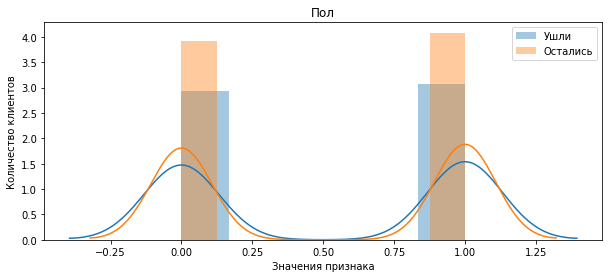

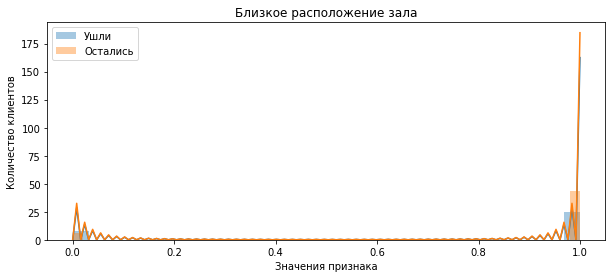

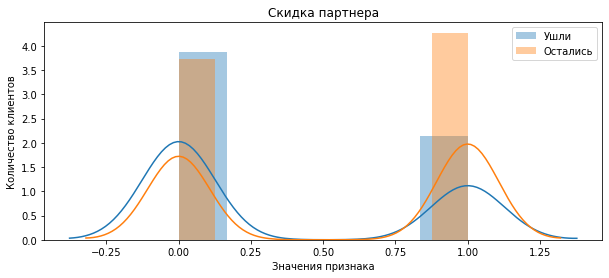

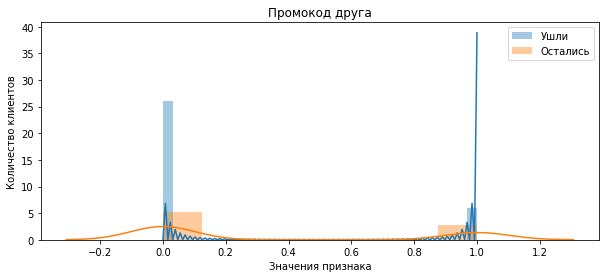

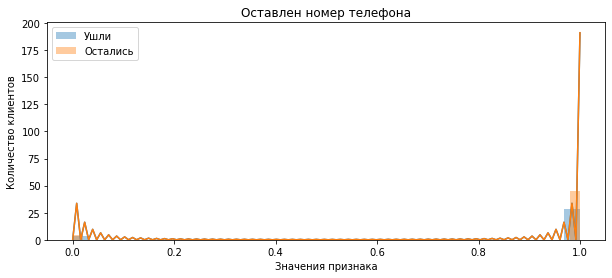

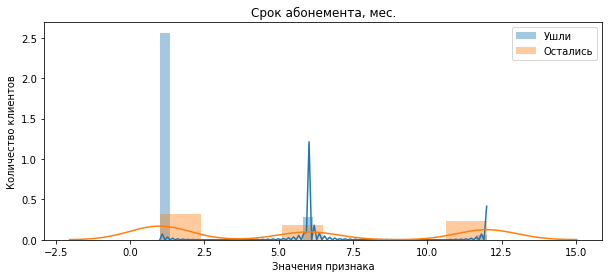

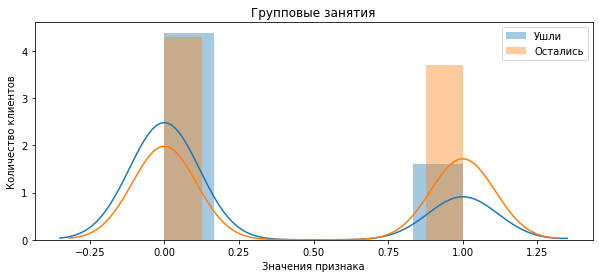

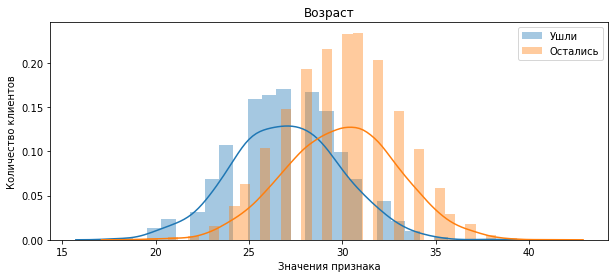

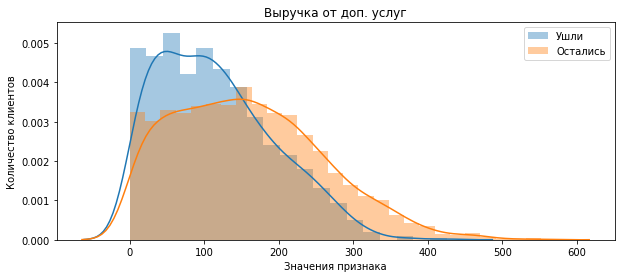

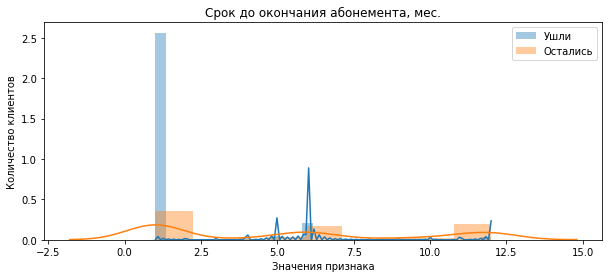

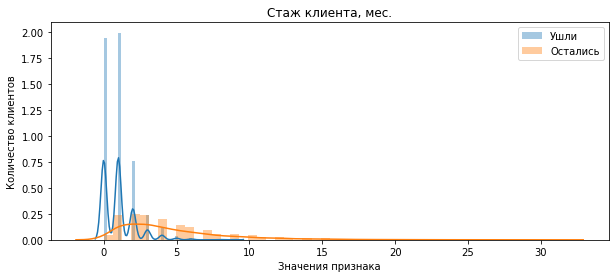

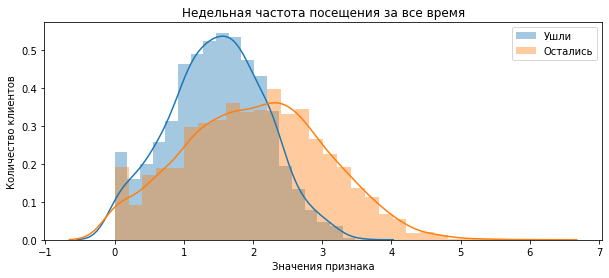

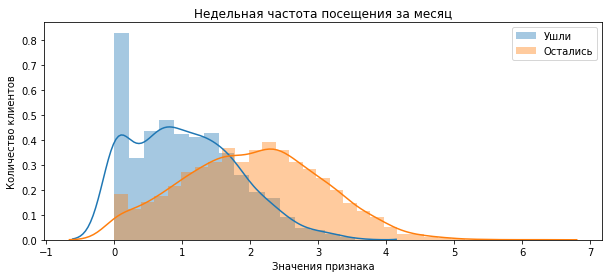

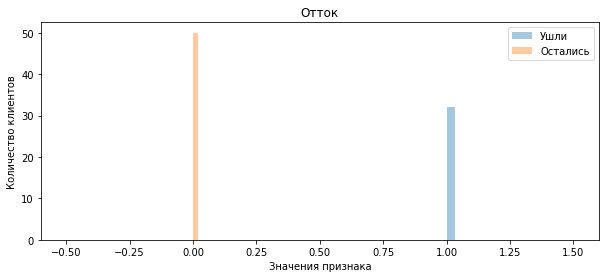

In [11]:
temp = gym.copy()
temp1 = temp[temp['churn'] == 1]
temp0 = temp[temp['churn'] == 0]

left = temp[temp['churn']==1]
stayed = temp[temp['churn']==0]

for column in ['gender', 'near_location', 'partner', 'promo_friends', 'phone',
               'contract_period', 'group_visits', 'age', 'avg_additional_charges_total',
               'month_to_end_contract', 'lifetime', 'avg_class_frequency_total',
               'avg_class_frequency_current_month', 'churn']:
    plt.figure(figsize=(10,4))
    plt.title(column_dict[column])
    sns.distplot(temp1[column])
    sns.distplot(temp0[column])
    plt.legend(['Ушли', 'Остались'])
    plt.ylabel('Количество клиентов')
    plt.xlabel('Значения признака')
    plt.show()

✅ **Вывод**

В среднем на удержание клиента лучше сказывается партнерство с работодателем, покупка первого абонемента по акции и посещение групповых занятий. Ушедшие клиенты в среднем моложе, имеют меньший оставшийся срок действия абонемента и в текущем месяце посещали зал раз в неделю. По всем показателям процент оттока меньше. Различающееся распределение внутри показателя наблюдается в столбце partner - сотрудники партнеров охотнее остаются клиентами. Также очень мало клиентов уходят, когда их абонемент дейстует 6 и более месяцев.

Для количественных признаков построим боксплот и также сравним распределения:

In [14]:
# переименую столбцы
gym.rename(columns={
    'gender': 'Пол',
    'near_location': 'Близкое расположение зала',
    'partner': 'Скидка партнера',
    'promo_friends': 'Промокод друга',
    'phone': 'Оставлен номер телефона',
    'contract_period': 'Срок абонемента, мес.',
    'group_visits': 'Групповые занятия',
    'age': 'Возраст',
    'avg_additional_charges_total': 'Выручка от доп. услуг',
    'month_to_end_contract': 'Срок до окончания абонемента, мес.',
    'lifetime': 'Стаж клиента, мес.',
    'avg_class_frequency_total': 'Недельная частота посещения за все время',
    'avg_class_frequency_current_month': 'Недельная частота посещения за месяц',
    'churn': 'Отток'},inplace=True)

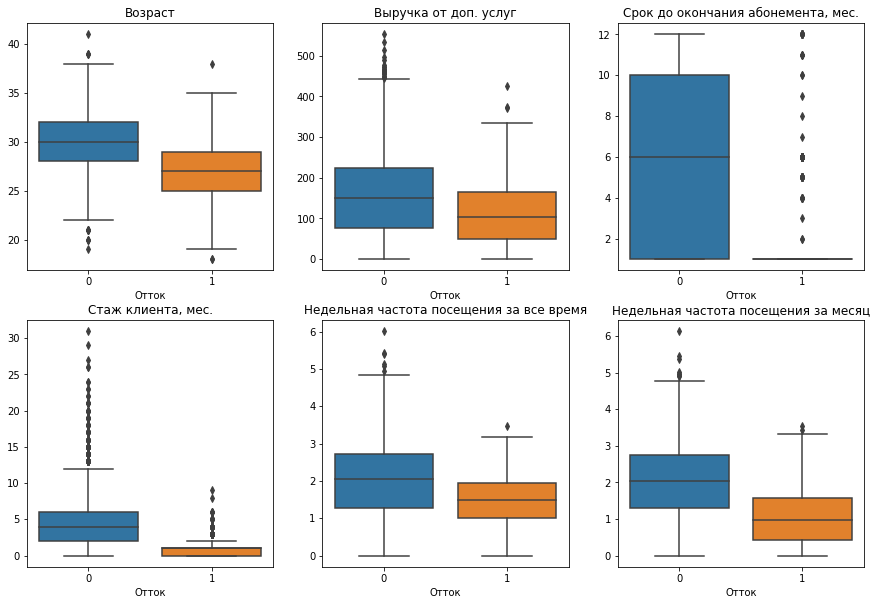

In [16]:
sub_gym = ['Возраст',
           'Выручка от доп. услуг', 
           'Срок до окончания абонемента, мес.', 
           'Стаж клиента, мес.', 
           'Недельная частота посещения за все время', 
           'Недельная частота посещения за месяц']

plt.figure(figsize=(15,10))

for i, col in enumerate(sub_gym):
    sns.boxplot(x='Отток', y=col, data=gym, ax=plt.subplot(2,3,i+1))
    plt.ylabel('')
    plt.title(col)

Заметна разница в распределении количества месяцев до окончания абонемента - среди отточных клиентов очень мало тех, у кого этот срок составлял больше месяца. В разрезе дополнительных затрат можно предположить следующую закономерность - чем больше клиент тратит на дополнительные услуги, тем реже он нас покидает. "Патриатизм" чаще всего не превышает 3 месяца для тем, кто попадает в отток.

### Матрица корреляций
<a id="#8"></a>

Text(0.5, 1, 'Матрица корреляций')

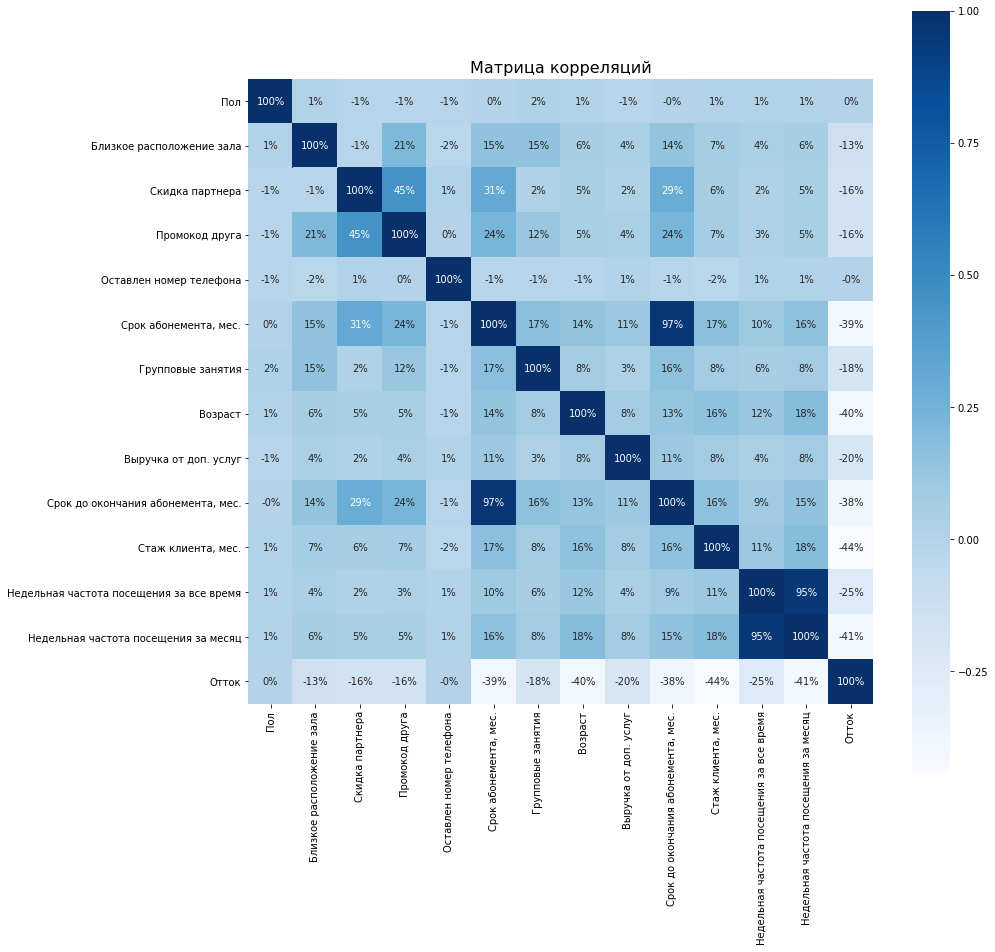

In [17]:
# строим матрицу корреляций
mat_cor = gym.corr().round(2)

plt.figure(figsize=(14, 14))
sns.heatmap(
    mat_cor, 
    annot=True, 
    square = True, 
    fmt='.0%',
    cmap="Blues"
)

plt.title('Матрица корреляций', fontsize=16)

✅ **Вывод**

Фитнес - центр посещают в среднем 2 раза в неделю, примерно в равном количестве как мужчины, так и женщины, проживающие или работающие в том же районе, возраст 29 лет, на доп. услуги тратят 158р.

**Факт оттока больше, если:**

- клиент купил абонемент на 1 месяц;
- клиент более молодой;
- срок до окончания текущего действующего абонемента - месяц;

**Факт оттока меньше, если:**

- книент проживает / работает в том же районе;
- клиент является клиентом - партнером;
- клиент пришел по акции "приведи друга";
- клиент купил абонемент на 12 месяцев;
- клиент посещает групповые занятия;
- клиент более возрастной;
- срок до окончания текущего действующего абонемента - больше месяца;
- клиент давно ходит в фитнес - центр;
- клиент более 2х раз в неделю посещает фитнес - центр;

## Модель прогнозирования оттока клиентов
<a id="#9"></a>

Построим модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце.

Разделим данные на признаки (матрицу X) и целевую переменную (веткор y) и разобъём данные на обучающую и валидационную выборку функцией train_test_split().


In [18]:
mod_gym = gym.copy()
X = mod_gym.drop('Отток', axis=1)
y = mod_gym['Отток'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=0)

In [19]:
# стандартизируем данные 
scaler = StandardScaler()
X_train_st = scaler.fit_transform(X_train)
X_test_st = scaler.transform(X_test)

In [20]:
# определим функцию, которая будет выводить наши метрики
def print_all_metrics(y_true, y_pred, y_proba, title = 'Метрики классификации'):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    print('\tF1: {:.2f}'.format(f1_score(y_true, y_pred)))

### Логистическа регрессия:
<a id="#10"></a>

In [21]:
# алгоритм для модели
lr_model = LogisticRegression(solver='liblinear')

# обучим модель
lr_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:,1]

### Случайный лес:
<a id="#11"></a>

In [22]:
# алгоритм для модели
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)

# обучим модель
rf_model.fit(X_train_st, y_train)

# воспользуемся уже обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:,1]

### Оценка метрики accuracy, precision и recall для обеих моделей на валидационной выборке. 
<a id="#12"></a>

In [23]:
print_all_metrics(y_test, lr_predictions, lr_probabilities , title='Метрики для модели логистической регрессии:')
print_all_metrics(y_test, rf_predictions, rf_probabilities, title = 'Метрики для модели случайного леса:')

Метрики для модели логистической регрессии:
	Accuracy: 0.94
	Precision: 0.90
	Recall: 0.85
	F1: 0.87
Метрики для модели случайного леса:
	Accuracy: 0.92
	Precision: 0.88
	Recall: 0.83
	F1: 0.85


✅ **Вывод**

Логистическая регрессия показала себя лучше, чем модель случайный лес на основании метрик:

  -  Accuracy (доля правильных ответов) 0.94 у логистической регрессии против 0.92 у модели случайный лес;
  -  Precision (точность) 0.90 против 0.88;
  -  Recall (полнота) 0.85 против 0.83;
  -  F1 - 0.87 против 0.85.

## Кластеризация пользователей
<a id="#13"></a>

Порядок кластеризации пользователей:

    - стандартизация данных,
    - построение матрицы расстояний,
    - построение дендрограммы,
    - обучение модели кластеризации,
    - прогнозирование кластеров клиентов,
    - построение распределения признаков для кластеров,
    - анализ средних значений,
    - расчет доли оттока по кластеру.



<div class="alert alert-danger">

**Комментарий ревьювера**

Переменную churn нужно было исключить из данных, это указано в задании. Придется переделать весь этап :(
    
Попробую объяснить на очень утрированном примере.
 
Представь, что у нас есть выборка по фруктам c разными характеристиками (форма, цвет, наличие листа, пятнышки и т.д.). Мы пытались построить классификационную модель, чтобы предсказывать цвет фрукта (зеленый или розовый). Затем мы решили убрать цвет из данных и посмотреть, можно ли разделить фрукты по другим характеристикам так, чтобы мы могли выделить кластеры, которые с наибольшей вероятностью окажутся, например, зелеными.
    
Ниже попыталась продемонстрировать на интуитивном уровне, как бы происходило разделение на группы без и с переменной цвета.
    
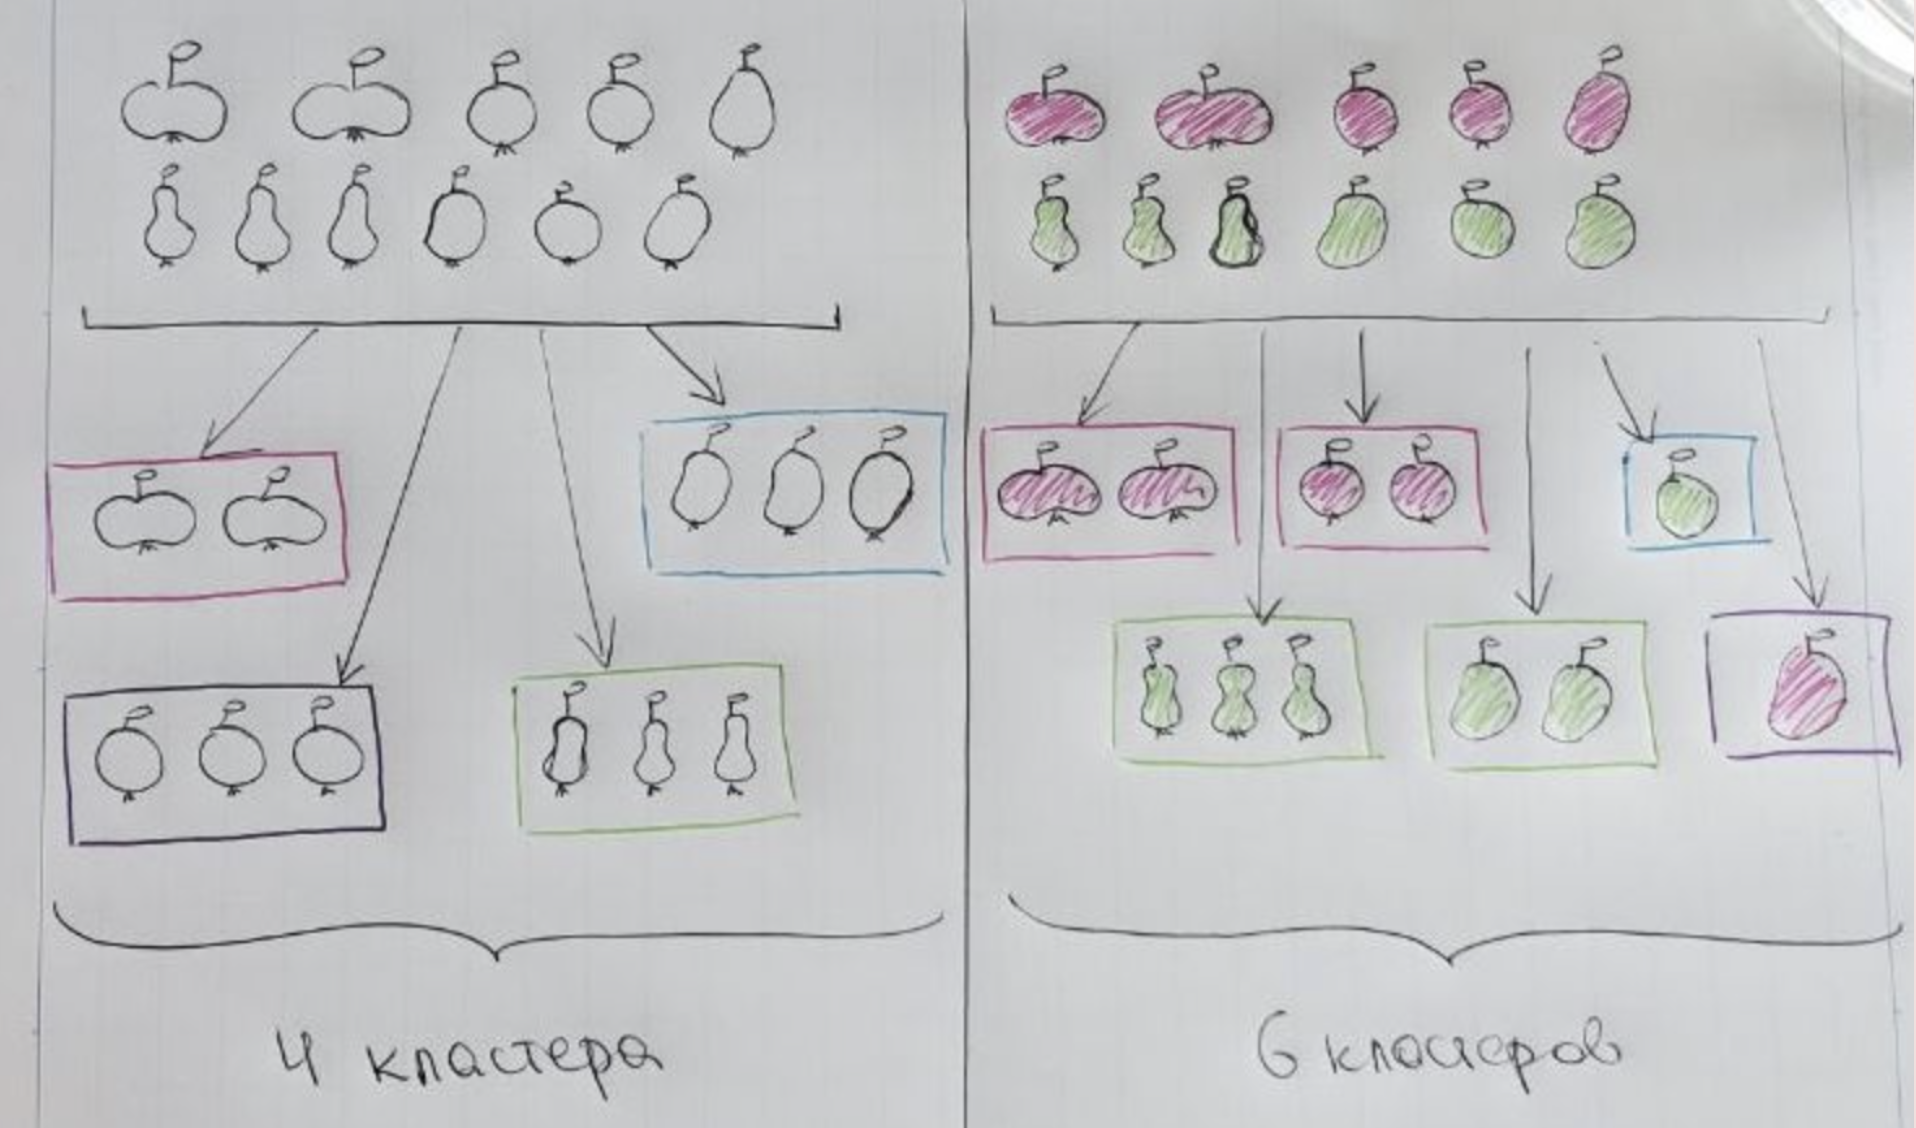
    
При добавлении переменной churn, происходит такая же ситуация. Данные становятся более разделимы из-за дополнительной информации. Но такая кластеризация не имеет смысла, так как мы получим один кластер с очень высоким оттоком, а все остальные - с незначительным. А наша цель просто понять, какие группы клиентов есть в клубе, а после уже анализировать эти группы на склонность к оттоку.

In [24]:
gym_cl = gym.copy()

gym_cl= gym_cl.drop('Отток', axis=1)

# стандартизация данных
x_cl= scaler.fit_transform(gym_cl)

# построение матрицы расстояний 
linked = linkage(x_cl, method = 'ward')

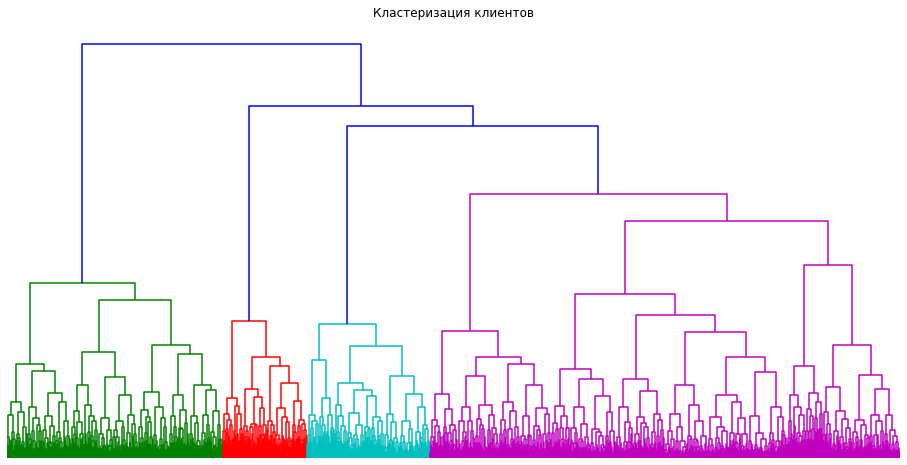

In [25]:
# построение дендрограммы
plt.figure(figsize=(16, 8))  
dendrogram(linked, orientation='top', no_labels=True)
sns.despine(
    left=True, 
    bottom=True
)
plt.gca().set_yticks([])
plt.title('Кластеризация клиентов')
plt.show()

Оптимальное число кластеров — 5, согласно результатам визуального анализа дендрограммы.

In [26]:
# задаём модель k_means с числом кластеров 5

km = KMeans(n_clusters=5, random_state=0)
# прогнозируем кластеры для наблюдений
labels = km.fit_predict(x_cl)

In [27]:
gym['Кластер'] = labels

In [28]:
# посмотрим на средние значения
gym.drop(['Отток'], axis=1).groupby('Кластер').mean().T

Кластер,0,1,2,3,4
Пол,0.50,0.52,0.50,0.49,0.56
Близкое расположение зала,0.96,0.86,0.00,1.00,0.98
Скидка партнера,0.78,0.47,0.46,0.35,0.36
Промокод друга,0.57,0.31,0.08,0.24,0.23
Оставлен номер телефона,1.00,0.00,1.00,1.00,1.00
"Срок абонемента, мес.",10.88,4.79,2.35,1.95,2.67
Групповые занятия,0.54,0.43,0.22,0.34,0.47
Возраст,29.98,29.30,28.48,28.17,30.13
Выручка от доп. услуг,160.71,143.96,135.46,131.62,161.72
"Срок до окончания абонемента, мес.",9.95,4.48,2.20,1.86,2.46


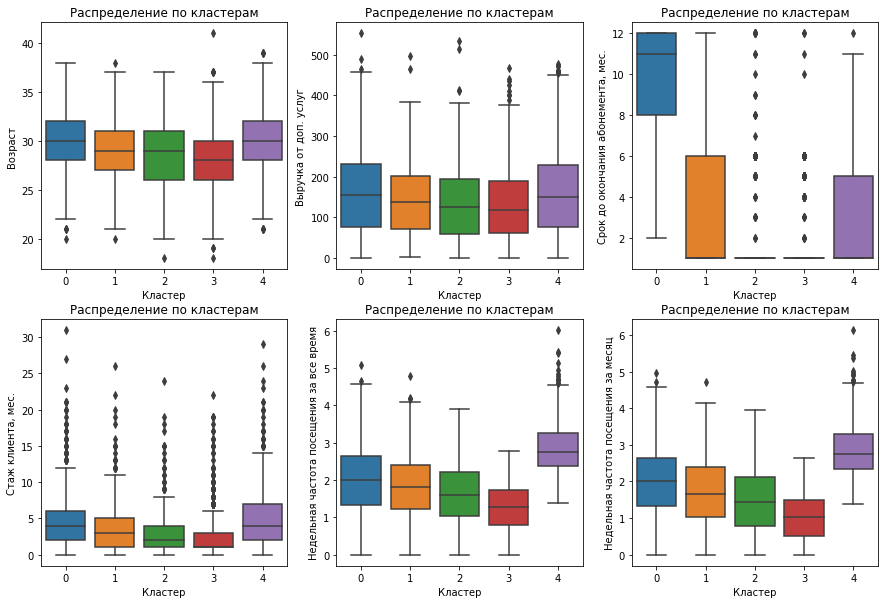

In [29]:
# посмотрим на распределения
plt.figure(figsize=(15,10))
for i, col in enumerate(sub_gym):
    sns.boxplot(x='Кластер', y=col, data=gym, ax=plt.subplot(2,3,i+1))
    plt.title("Распределение по кластерам")

In [35]:
# доля оттока по каждому кластеру
round(gym.query('Отток==1').groupby('Кластер')['Отток']\
      .count() / gym.groupby('Кластер')['Отток'].count(),2).map('{:,.0%}'.format)

Кластер
0     3%
1    27%
2    44%
3    51%
4     7%
Name: Отток, dtype: object

✅ **Вывод**

В соответствии с проведенным анализом, можно сделать вывод, что 1 и 4 кластеры самые надежные. В них попали клиенты, которые:

   - проживают / работают в том же районе, что и фитнес центр;
   - в возрасте 30+
   - являются постоянными клиентами
   - чаще посещеяют зал в неделею и за месяц
   - активно приобретают доп. услуги
   
Наименее привлекательными являются клиенты попавшие в 3 и 4 кластеры. Это клиенты которые, наверняка, не вернутся в клуб:
   - новички клуба
   - в возрасте от 25 до 28 лет
   - меньше всех приобретают доп.услуги
   - с истекающим в срок абонементом
   - реже остальных посещающие зал в неделю и месяц
   

## Выводы и рекомендации
<a id="#14"></a>

✅**Вывод**

В рамках разрабоки стратегии взаимодействия с пользователями, были проанализированы данные посещения клубов сети фитнес-центров «Культурист-датасаентист».

***Исследование представленных данных показало, что:***
- Датафрейм состоит из 4000 строк и 14 столбцов.
- В датафрейме нет пропусков и дубликатов
- 7 столбцов совершенно точно относятся к уже нормализованным категорийным переменным - в 6 из 7 столбцов по 2 возможных значения. В столбце 'Contract_period' используются три возможных варианта.
- Данные полные, типизация корректна.

***Портреты клиентов выглядят следующим образом:***
- Клиенты в выборке равномерно разделены по полу
- Большинство клиентов живет рядом с клубом
- Половина клиентов являются сотрудниками компаний-партнеров
- 30% клиентов оплатили свой первый абонемент в рамках акции "приведи друга"
- Большинство указали мобильный телефон
- Больше половины клиентов покупают абонемент на 1 месяц
- Около половины клиентов посещают групповые занятия
- Средний возраст клиента - 29 лет
- В среднем, на другие услуги клуба клиент тратит 147 у.е.
- Среднее "время жизни" клиента - 3-4 месяца
- Средняя частоста посещений в неделю - 1-2 раза

Анализ оттока клиентов показал, что в среднем на удержание клиента лучше сказывается партнерство с работодателем, покупка первого абонемента по акции и посещение групповых занятий. Ушедшие клиенты в среднем моложе, имеют меньший оставшийся срок действия абонемента и в текущем месяце посещали зал раз в неделю. По всем показателям процент оттока меньше. Различающееся распределение внутри показателя наблюдается в столбце partner - сотрудники партнеров охотнее остаются клиентами. Также очень мало клиентов уходят, когда их абонемент дейстует 6 и более месяцев.

Проведение статистической взаимосвязи определило, что фитнес - центр посещают в среднем 2 раза в неделю, примерно в равном количестве как мужчины, так и женщины, проживающие или работающие в том же районе, возраст 29 лет, на доп. услуги тратят 158р.

***Факт оттока будет больше, если клиент является:***

- новичком клуба
- в возрасте от 25 до 28 лет
- меньше всех приобретает доп.услуги
- с истекающим в срок абонементом
- реже остальных посещает зал за неделю и месяц

***Факт оттока будет меньше, если клиенты:***

- проживают / работают в том же районе, что и фитнес центр;
- в возрасте 30+
- являются постоянными клиентами
- чаще среднего значения посещеяют зал в неделею и за месяц
- активно приобретают доп. услуги

✅ **Рекомендации**

- Сделать простарнство фитнесс центра более привлекательное для соц сетей (например Instagram) что подтянет молодежь,скорее больше молодых девушек, которые в свою очередь будут привлекать больше молодых людей и отток посетителей до 30 лет снизится
- Условия рассрочки или абонемента в кредит
- Предлагать за два месяца до окончания абонемента условия продления абонемента на выгодных условиях (скидка за продление)
- Предлагать больше бесплатных групповых занятий для клиентов, чтобы увеличить их среднее количество посещений в неделю
- Мониторить клиентов, отсутствующих какое-то время и присылать им напоминание
- Добавить опцию сменить зал (если сеть), в случае, если клиент переехал и ему не удобно добираться
